### Complete TensorFlow mixed-precision implementation with Bert

*1.use bert in tensorflow 2.1*
*2.add the sentiment frquence: positive negative neutral*
*3.use lr warmup*
*4. focal loss*
*5.get the best logits*
*6.data argumentation*

In [1]:
import numpy as np
import pandas as pd
from math import ceil, floor
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.initializers import TruncatedNormal
from sklearn import model_selection
from transformers import BertConfig, TFBertPreTrainedModel, TFBertMainLayer
from transformers import RobertaConfig, TFRobertaPreTrainedModel, TFRobertaMainLayer, TFRobertaModel
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
from copy import deepcopy

import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

nltk.download('stopwords')
stop = set(stopwords.words('english'))
stop

In [2]:
# read csv files
train_df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
train_df.dropna(inplace=True)

test_df = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
test_df.loc[:, "selected_text"] = test_df.text.values

submission_df = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')

print("train shape =", train_df.shape)
print("test shape  =", test_df.shape)

# set some global variables
PATH = "../input/tf-roberta/"
MAX_SEQUENCE_LENGTH = 96
# TOKENIZER = BertWordPieceTokenizer(f"../input/bert-base-uncased/vocab.txt", lowercase=True, add_special_tokens=False)
TOKENIZER = ByteLevelBPETokenizer(vocab_file=f"{PATH}/vocab-roberta-base.json", 
                                  merges_file=f"{PATH}/merges-roberta-base.txt", 
                                  lowercase=True, 
                                  add_prefix_space=True)

sentiment_dict = {"positive": ["good", "happy", "love", "day", "thanks", "great", "fun", "nice", "hope", "thank"],
                  "negative": ["miss", "sad", "sorry", "bad", "hate", "sucks", "sick", "like", "feel", "bored"],
                  "neutral": ["get", "go", "day", "work", "going", "quot", "lol", "got", "like", "today"]}

# let's take a look at the data
train_df.head(10)


train shape = (27480, 4)
test shape  = (3534, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,sooo sad,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","sons of * * * * ,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,wow . . . u just became cooler .,positive


```
I. Set up preprocessing and dataset/datagenerator
```


In [3]:
def preprocess(tweet, selected_text, sentiment):
    """
    Will be used in tf.data.Dataset.from_generator(...)

    """
    
    # The original strings have been converted to
    # byte strings, so we need to decode it
    tweet = tweet.decode('utf-8')
    selected_text = selected_text.decode('utf-8')
    sentiment = sentiment.decode('utf-8')

    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    
    # tokenize with offsets
    enc = TOKENIZER.encode(tweet)
    input_ids_orig = enc.ids
    offsets = enc.offsets
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)

    target_start = target_idx[0]
    target_end = target_idx[-1]
    
    # add sentiment word frequency
    sentiment_frequency = []
    pos_fre = 0
    neg_fre = 0
    neu_fre = 0
    for token in enc.tokens:
        token = token.replace("Ġ", "")
        if token in sentiment_dict["positive"]:
            pos_fre += 1
        if token in sentiment_dict["negative"]:
            neg_fre += 1
        if token in sentiment_dict["neutral"]:
            neu_fre += 1
    sentiment_frequency.append(str(pos_fre))
    sentiment_frequency.append(str(neg_fre))
    sentiment_frequency.append(str(neu_fre))
    enc_sentiment = TOKENIZER.encode(" ".join(sentiment_frequency))
    
    
    # add and pad data (hardcoded for BERT)
    # --> [CLS] sentiment [SEP] input_ids [SEP] [PAD]
    sentiment_map = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }

    input_ids = [0] + input_ids_orig + [2] + [2] + [sentiment_map[sentiment]] + enc_sentiment.ids + [2]
    input_type_ids = [0] * 1 + [0] * (len(input_ids_orig) + 7)
    attention_mask = [1] * (len(input_ids_orig) + 8)
    offsets = [(0, 0)] + offsets + [(0, 0)] * 7
    target_start += pos_offsets
    target_end += pos_offsets

    padding_length = MAX_SEQUENCE_LENGTH - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([1] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
        input_type_ids = input_type_ids + ([0] * padding_length)
        offsets = offsets + ([(0, 0)] * padding_length)
    elif padding_length < 0:
        input_ids = input_ids[:padding_length - 1] + [2]
        attention_mask = attention_mask[:padding_length - 1] + [1]
        input_type_ids = input_type_ids[:padding_length - 1] + [0]
        offsets = offsets[:padding_length - 1] + [(0, 0)]
        if target_start >= MAX_SEQUENCE_LENGTH:
            target_start = MAX_SEQUENCE_LENGTH - 1
        if target_end >= MAX_SEQUENCE_LENGTH:
            target_end = MAX_SEQUENCE_LENGTH - 1

    return (
        input_ids, attention_mask, input_type_ids, offsets,
        target_start, target_end, tweet, selected_text, sentiment,
    )

class TweetSentimentDataset(tf.data.Dataset):
    
    OUTPUT_TYPES = (
        tf.dtypes.int32,  tf.dtypes.int32,   tf.dtypes.int32, 
        tf.dtypes.int32,  tf.dtypes.float32, tf.dtypes.float32,
        tf.dtypes.string, tf.dtypes.string,  tf.dtypes.string,
    )
    
    OUTPUT_SHAPES = (
        (MAX_SEQUENCE_LENGTH,),   (MAX_SEQUENCE_LENGTH,), (MAX_SEQUENCE_LENGTH,), 
        (MAX_SEQUENCE_LENGTH, 2), (),                     (),
        (),                       (),                     (),
    )
    
    # AutoGraph will automatically convert Python code to
    # Tensorflow graph code. You could also wrap 'preprocess' 
    # in tf.py_function(..) for arbitrary python code
    def _generator(tweet, selected_text, sentiment):
        for tw, st, se in zip(tweet, selected_text, sentiment):
            yield preprocess(tw, st, se)
    
    # This dataset object will return a generator
    def __new__(cls, tweet, selected_text, sentiment):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=cls.OUTPUT_TYPES,
            output_shapes=cls.OUTPUT_SHAPES,
            args=(tweet, selected_text, sentiment)
        )
    
    @staticmethod
    def create(dataframe, batch_size, shuffle_buffer_size=-1):
        dataset = TweetSentimentDataset(
            dataframe.text.values, 
            dataframe.selected_text.values, 
            dataframe.sentiment.values
        )

        dataset = dataset.cache()
        if shuffle_buffer_size != -1:
            dataset = dataset.shuffle(shuffle_buffer_size)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        
        # d = next(iter(dataset))
        # print("Writing example in %d" % (len(dataframe)))
        # for i in range(5):
        #     print("*** Example ***")
        #     print("tokens: %s" % " ".join(TOKENIZER.encode(d[6].numpy()[i].decode("utf-8")).tokens))
        #     print("input_ids: %s" % " ".join([str(x) for x in d[0].numpy()[i]]))
        #     print("input_mask: %s" % " ".join([str(x) for x in d[1].numpy()[i]]))
        #     print("segment_ids: %s" % " ".join([str(x) for x in d[2].numpy()[i]]))
        #     print("selected_text: %s" % d[7].numpy()[i].decode("utf-8"))
        #     print("idx_start: %d" % d[4].numpy()[i])
        #     print("idx_end: %d" % d[5].numpy()[i])
        
        return dataset
        
def generate_fold_data(data, num_folds):
    kfold = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold_num, (train_idx, valid_idx) in enumerate(kfold.split(X=data.text, y=data.sentiment.values)):
        if fold_num == 0:
            save_data = data.iloc[valid_idx]
            save_data["kfold"] = fold_num
        else:
            _save_data = data.iloc[valid_idx]
            _save_data["kfold"] = fold_num
            save_data = pd.concat([save_data, _save_data], axis=0)
            
    save_data = save_data.reset_index(drop=True)
    # print(save_data.shape)
    # save_data.to_csv("train_5folds.csv", index=False)
    return save_data

In [ ]:
def replace_special_char(text_orign, selected_text_orign):
    tweet = " " + " ".join(str(text_orign).split())
    selected_text = " " + " ".join(str(selected_text_orign).split())
    
    if "¿½" in tweet and "¿½" not in selected_text:
        tweet = tweet.replace("¿½", "")
        
    if "ï" in tweet and "ï" not in selected_text:
        tweet = tweet.replace("ï", "i")
        
    return tweet.strip()
    
def align_texts_in_roberta(text_orign, selected_text_orign, tokenizer):
    """
    align the text_orign and selected_text_orign
    :param text_orign:
    :param selected_text_orign:
    :return:
    """
    tweet = " " + " ".join(str(text_orign).split())
    selected_text = " " + " ".join(str(selected_text_orign).split())

    text_list = tokenizer.encode(tweet)
    offsets = text_list.offsets

    selected_text_list = tokenizer.encode(selected_text)

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1

    target_idx = []
    for j, (offset1, offset2) in enumerate(offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)

    target_start = target_idx[0]
    target_end = target_idx[-1]

    decoded_text = ""
    for i in range(target_start, target_end+1):
        decoded_text += tweet[offsets[i][0]:offsets[i][1]]
        if (i+1) < len(offsets) and offsets[i][1] < offsets[i+1][0]:
            decoded_text += " "
    return decoded_text.strip()

train_df["text"] = train_df.apply(lambda x: replace_special_char(x["text"], x["selected_text"]), axis=1)
train_df["selected_text"] = train_df.apply(lambda x : align_texts_in_roberta(x["text"], x["selected_text"], TOKENIZER), axis=1)

In [ ]:
def remove_stopwords(text):
        if text is not None:
            result = []
            itokens_list = text.split(" ")
            for itoken in itokens_list:
                if itoken not in stop:
                    result.append(itoken)
            return " ".join(result)
        else:
            return None

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    exclude = set(string.punctuation)
    s = ''.join(ch for ch in text if ch not in exclude)
    return s

def remove_char(text):
    del_dict = {"Aam dogs going die somebody doesnt save them": "dogs going die somebody doesnt save them",
                "HOPE h": " HOPE",
                "excited ab": "excited",
                "released stinks": "stinks",
                "Wave looks interesting http": "Wave looks interesting"}
    for key in del_dict:
        if key == text:
            return del_dict[key]
    return text

def clean_df(df, train=True):
    df["dirty_text"] = df['text']
    df['text'] = df['text'].apply(lambda x: remove_emoji(x))
    df['text'] = df['text'].apply(lambda x : remove_URL(x))
    df['text'] = df['text'].apply(lambda x : remove_html(x))
    df['text'] = df['text'].apply(lambda x : remove_stopwords(x)) 
    df['text'] = df['text'].apply(lambda x : remove_punct(x))
    df.text = df.text.replace('\s+', ' ', regex=True)
    
    if train:
        df['selected_text'] = df['selected_text'].apply(lambda x: remove_emoji(x))
        df['selected_text'] = df['selected_text'].apply(lambda x : remove_URL(x))
        df['selected_text'] = df['selected_text'].apply(lambda x : remove_html(x))
        df['selected_text'] = df['selected_text'].apply(lambda x : remove_stopwords(x))
        df['selected_text'] = df['selected_text'].apply(lambda x : remove_punct(x))
        df.selected_text = df.selected_text.replace('\s+', ' ', regex=True)
        df['selected_text'] = df['selected_text'].apply(lambda x : remove_char(x))
    
    return df

def post_process(s):
    a = re.findall('[^A-Za-z0-9]',s)
    b = re.sub('[^A-Za-z0-9]+', '', s)

    try:
        if a.count('.')==3:
            text = b + '. ' + b + '..'
        elif a.count('!')==4:
            text = b + '! ' + b + '!! ' +  b + '!!!'
        else:
            text = s
        return text
    except:
        return text

# data augmentation 
train_df_aug = deepcopy(train_df)
train_df_aug = clean_df(train_df_aug)
train_df_aug = train_df_aug.drop(train_df_aug[train_df_aug["dirty_text"] == train_df_aug["text"]].index).reset_index(drop=True)
train_df_aug = train_df_aug.drop(train_df_aug[train_df_aug["sentiment"] == "neutral"].index).reset_index(drop=True)
train_df_aug.rename(columns={'dirty_text':'kfold'}, inplace=True)
train_df_aug = train_df_aug.drop(train_df_aug[train_df_aug["selected_text"] == ""].index).reset_index(drop=True)
train_df_aug = train_df_aug.drop(train_df_aug[train_df_aug["selected_text"] == " "].index).reset_index(drop=True)


```
II. Set up transformer model and functions
```

In [4]:
class RoBertQAModel(TFRobertaPreTrainedModel):
# class RoBertQAModel(TFBertPreTrainedModel):
    
    DROPOUT_RATE = 0.1
    NUM_HIDDEN_STATES = 2
    
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        
        self.bert = TFRobertaModel.from_pretrained(PATH +'pretrained-roberta-base.h5',config=config)
        # self.bert = TFRobertaMainLayer(config, name="bert")
        self.concat = L.Concatenate()
        self.dropout = L.Dropout(self.DROPOUT_RATE)
        self.qa_outputs = L.Dense(
            config.num_labels, 
            kernel_initializer=TruncatedNormal(stddev=config.initializer_range),
            dtype='float32',
            name="qa_outputs")
        self.conv1d_128 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU = L.LeakyReLU()
        self.dense = L.Dense(1, dtype='float32')
        self.flatten = L.Flatten()
        
        self.dropout_2 = L.Dropout(self.DROPOUT_RATE)
        self.conv1d_128_2 = L.Conv1D(128, 2, padding='same')
        self.conv1d_64_2 = L.Conv1D(64, 2, padding='same')
        self.leakyreLU_2 = L.LeakyReLU()
        self.dense_2 = L.Dense(1, dtype='float32')
        self.flatten_2 = L.Flatten()
        
        
    @tf.function
    def call(self, inputs, **kwargs):
        # outputs: Tuple[sequence, pooled, hidden_states]
        x, _, hidden_states = self.bert(inputs, **kwargs)
        
        x1 = self.dropout(hidden_states[-1], training=kwargs.get("training", False))
        x1 = self.conv1d_128(x1)
        x1 = self.leakyreLU(x1)
        x1 = self.conv1d_64(x1)
        x1 = self.dense(x1)
        start_logits = self.flatten(x1)
        start_logits = tf.keras.layers.Activation('softmax')(start_logits)
        
        x2 = self.dropout_2(hidden_states[-2], training=kwargs.get("training", False))
        x2 = self.conv1d_128_2(x2)
        x2 = self.leakyreLU_2(x2)
        x2 = self.conv1d_64_2(x2)
        x2 = self.dense_2(x2)
        end_logits = self.flatten_2(x2)
        end_logits = tf.keras.layers.Activation('softmax')(end_logits)
    
        return start_logits, end_logits

@tf.function
def train_step(inputs, y_true, current_step):
    def _train_step(inputs, y_true, current_step):
        with tf.GradientTape() as tape:
            y_pred = model(inputs, training=True)
            loss  = loss_fn(y_true[0], y_pred[0])
            loss += loss_fn(y_true[1], y_pred[1])
            # scaled_loss = optimizer.get_scaled_loss(loss)

        gradients = tape.gradient(loss, model.trainable_variables)
        # gradients = optimizer.get_unscaled_gradients(scaled_gradients)
        optimizer.learning_rate = lr_decay_fn(learning_rate, num_train_steps, num_warmup_steps, current_step)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss, y_pred
    
    loss, y_pred = strategy.experimental_run_v2(_train_step, args=(inputs, y_true, current_step,))
    sum_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=0)
    return sum_loss, y_pred

"""
def train(model, strategy, dataset, loss_fn, optimizer, current_step, loss_step, data_len, fold_num, lr_decay_fn):
    
    @tf.function
    def train_step(inputs, y_true, current_step):
        def _train_step(inputs, y_true, current_step):
            with tf.GradientTape() as tape:
                y_pred = model(inputs, training=True)
                loss  = loss_fn(y_true[0], y_pred[0])
                loss += loss_fn(y_true[1], y_pred[1])
                # scaled_loss = optimizer.get_scaled_loss(loss)
    
            gradients = tape.gradient(loss, model.trainable_variables)
            # gradients = optimizer.get_unscaled_gradients(scaled_gradients)
            optimizer.learning_rate = lr_decay_fn(learning_rate, num_train_steps, num_warmup_steps, current_step)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            return loss, y_pred
        
        loss, y_pred = strategy.experimental_run_v2(_train_step, args=(inputs, y_true, current_step,))
        sum_loss = strategy.reduce(tf.distribute.ReduceOp.SUM, loss, axis=0)
        return sum_loss, y_pred
    
    epoch_loss = 0.
    tk0 = tqdm(dataset, total=data_len, desc="Training: " + str(fold_num))
        
    with strategy.scope():
        for batch_num, sample in enumerate(tk0):
            # current_step.assign_add(1)
            # loss, y_pred = strategy.experimental_run_v2(_train_step, args=(sample[:3], sample[4:6], current_step,))
            sum_loss, y_pred = train_step(sample[:3], sample[4:6], current_step)
    
            # # for i in range(strategy.num_replicas_in_sync):
            # #     epoch_loss += loss.values[i]
            # epoch_loss += sum_loss
            # loss_step.append(epoch_loss/(batch_num+1))
            # 
            # tf.print("training ... batch", batch_num+1, ": ", "train loss ", epoch_loss/(batch_num+1))
"""

def predict(model, strategy, dataset, loss_fn, optimizer, data_len, fold_num):
    
    @tf.function
    def predict_step(inputs):
        def _predict_step(inputs):
            return model(inputs)
        # replica value
        y_pred = strategy.experimental_run_v2(_predict_step, args=(inputs,))
        return y_pred
        
    def to_numpy(*args):
        out = []
        for arg in args:
            if arg.dtype == tf.string:
                arg = [s.decode('utf-8') for s in arg.numpy()]
                out.append(arg)
            else:
                arg = arg.numpy()
                out.append(arg)
        return out
    
    # Initialize accumulators
    offset = tf.zeros([0, MAX_SEQUENCE_LENGTH, 2], dtype=tf.dtypes.int32)
    text = tf.zeros([0,], dtype=tf.dtypes.string)
    selected_text = tf.zeros([0,], dtype=tf.dtypes.string)
    sentiment = tf.zeros([0,], dtype=tf.dtypes.string)
    pred_start = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    pred_end = tf.zeros([0, MAX_SEQUENCE_LENGTH], dtype=tf.dtypes.float32)
    
    tk0 = tqdm(dataset, total=data_len, desc="Validating or Testing: " + str(fold_num))
    
    with strategy.scope():
        for batch_num, sample in enumerate(tk0):
            
            # print(f"predicting ... batch {batch_num+1:03d}"+" "*20, end='\r')
            
            # y_pred = strategy.experimental_run_v2(predict_step, args=(sample[:3],))
            y_pred = predict_step(sample[:3])
            
            # add batch to accumulators
            for i in range(strategy.num_replicas_in_sync):
                pred_start = tf.concat((pred_start, y_pred[0].values[i]), axis=0)
                pred_end = tf.concat((pred_end, y_pred[1].values[i]), axis=0)
                
            offset = tf.concat((offset, sample[3]), axis=0)
            text = tf.concat((text, sample[6]), axis=0)
            selected_text = tf.concat((selected_text, sample[7]), axis=0)
            sentiment = tf.concat((sentiment, sample[8]), axis=0)

    # pred_start = tf.nn.softmax(pred_start)
    # pred_end = tf.nn.softmax(pred_end)
    
    pred_start, pred_end, text, selected_text, sentiment, offset = \
        to_numpy(pred_start, pred_end, text, selected_text, sentiment, offset)
    
    return pred_start, pred_end, text, selected_text, sentiment, offset


def decode_prediction(pred_start, pred_end, text, offset, sentiment, is_testing):
        
    def get_best_start_end_idxs(start_logits, end_logits):
        max_len = len(start_logits)
        a = np.tile(start_logits, (max_len, 1))
        b = np.tile(end_logits, (max_len, 1))
        c = np.tril(a + b.T, k=0).T
        c[c == 0] = -1000
        return np.unravel_index(c.argmax(), c.shape)
    
    def decode(pred_start, pred_end, text, offset):

        decoded_text = ""
        for i in range(pred_start, pred_end+1):
            decoded_text += text[offset[i][0]:offset[i][1]]
            if (i+1) < len(offset) and offset[i][1] < offset[i+1][0]:
                decoded_text += " "
        return decoded_text
    
    decoded_predictions = []
    for i in range(len(text)):
        if sentiment[i] == "neutral" or len(text[i].split()) < 2:
            decoded_text = text[i]
        else:
            if not is_testing:
                idx_start = np.argmax(pred_start[i])
                idx_end = np.argmax(pred_end[i])
            else:
                idx_start, idx_end = get_best_start_end_idxs(pred_start[i], pred_end[i])
            if idx_start > idx_end:
                idx_end = idx_start 
            decoded_text = str(decode(idx_start, idx_end, text[i], offset[i]))
            if len(decoded_text) == 0:
                decoded_text = text[i]
        decoded_predictions.append(decoded_text)
    
    return decoded_predictions

def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

@tf.function
def learning_rate_decay(init_lr, num_train_steps, num_warmup_steps, current_step):
    # Implements linear decay of the learning rate.
    learning_rate = tf.keras.optimizers.schedules.PolynomialDecay(
                    init_lr, num_train_steps, end_learning_rate=0.0, power=1.0)(current_step)

    if num_warmup_steps:
        global_steps_int = tf.cast(current_step, tf.dtypes.int32)
        warmup_steps_int = tf.constant(num_warmup_steps, dtype=tf.dtypes.int32)

        global_steps_float = tf.cast(global_steps_int, tf.dtypes.float32)
        warmup_steps_float = tf.cast(warmup_steps_int, tf.dtypes.float32)

        warmup_percent_done = global_steps_float / warmup_steps_float
        warmup_learning_rate = init_lr * warmup_percent_done

        if global_steps_int < warmup_steps_int:
            learning_rate = warmup_learning_rate
        else:
            learning_rate = learning_rate
        
    return learning_rate

@tf.function
def focal_loss(y_actual, y_pred, label_smoothing=0.15):
    # label smoothing
    y_actual = tf.cast(y_actual, tf.dtypes.int32)
    y_actual_one_hot = tf.one_hot(y_actual, MAX_SEQUENCE_LENGTH, axis=-1)
    # y_actual_one_hot = y_actual_one_hot * (1 - label_smoothing) + label_smoothing / MAX_SEQUENCE_LENGTH
    
    # focal loss
    result_reduce = tf.reduce_sum(y_actual_one_hot * y_pred, axis=-1)
    custom_loss = - tf.math.pow((1 - result_reduce), 1) * tf.math.log(result_reduce)
    custom_loss = custom_loss / global_batch_size
    return custom_loss

```
III. Run it all: 

model.create() -> dataset.create() -> train(train) ->
       -> predict(val).decode() -> predict(test).decode() -> submit
```

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


training ... batch 645 : train loss 1.983 


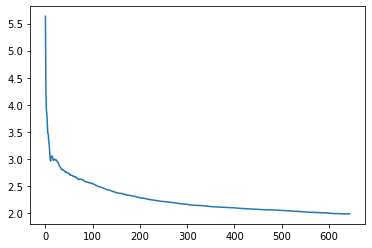

fold = 0 , epoch = 1 , jaccard = 0.548545


training ... batch 645 : train loss 1.584 


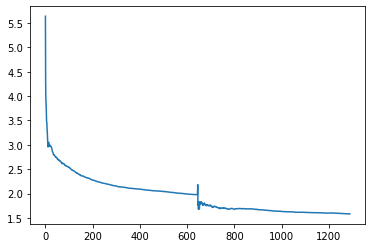

fold = 0 , epoch = 2 , jaccard = 0.567901


training ... batch 645 : train loss 1.411 


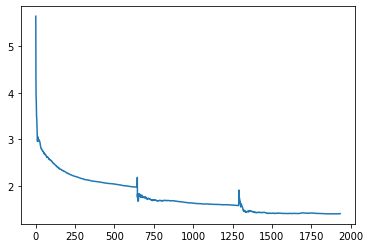

fold = 0 , epoch = 3 , jaccard = 0.570380


NameError: name 'BertQAModel' is not defined

In [5]:
num_folds = 5
num_epochs = 5
batch_size = 64
global_batch_size = batch_size * strategy.num_replicas_in_sync
learning_rate = 4e-5
num_train_steps = int(len(train_df) / batch_size * num_epochs)
num_warmup_steps = int(num_train_steps * 0.1)
pos_offsets = 1
    
data_df_5folds = generate_fold_data(train_df, 5)

with strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    lr_decay_fn = learning_rate_decay
    loss_fn = focal_loss
    config = RobertaConfig.from_json_file(os.path.join(PATH, "config-roberta-base.json"))
    config.output_hidden_states = True
    config.num_labels = 2
    model = RoBertQAModel(config=config)
    global_step = tf.Variable(0, name="global_step")
        
# def run(fold):
df_train_fold = data_df_5folds[data_df_5folds.kfold != fold].reset_index(drop=True)
df_valid_fold = data_df_5folds[data_df_5folds.kfold == fold].reset_index(drop=True)

df_train_fold = pd.concat([df_train_fold, train_df_aug])

num_train_batches = len(df_train_fold) // batch_size + int(len(df_train_fold) % batch_size != 0)
num_eval_batches = len(df_valid_fold) // batch_size + int(len(df_valid_fold) % batch_size != 0)
num_test_batches = len(test_df) // batch_size + int(len(test_df) % batch_size != 0)

# initialize test predictions
test_preds_start = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
test_preds_end = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
    
    # with strategy.scope():
        # optimizer = tf.keras.optimizers.Adam(learning_rate)
        # lr_decay_fn = learning_rate_decay
        # optimizer = tf.keras.mixed_precision.experimental.LossScaleOptimizer(
        #     optimizer, 'dynamic')
    
        # config = RobertaConfig(output_hidden_states=True, num_labels=2)
        # config = RobertaConfig.from_json_file(os.path.join(PATH, "config-roberta-base.json"))
        # config.output_hidden_states = True
        # config.num_labels = 2
        # model = RoBertQAModel(config=config)
    
        # loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        # loss_fn = focal_loss
    
loss_step = []
train_dataset = TweetSentimentDataset.create(
    df_train_fold, batch_size, shuffle_buffer_size=2048)
train_dataset = strategy.experimental_distribute_dataset(train_dataset)
valid_dataset = TweetSentimentDataset.create(
    df_valid_fold, batch_size, shuffle_buffer_size=-1)
valid_dataset = strategy.experimental_distribute_dataset(valid_dataset)
test_dataset = TweetSentimentDataset.create(
    test_df, batch_size, shuffle_buffer_size=-1)
test_dataset = strategy.experimental_distribute_dataset(test_dataset)

best_score = float('-inf')
for epoch_num in range(num_epochs):
    # train for an epoch
    # train(model, strategy, train_dataset, loss_fn, optimizer, global_step, loss_step, num_train_batches, fold, lr_decay_fn)
    for sample in train_dataset:
        train_step(sample[:3], sample[4:6], global_step)
        
        # # predict validation set and compute jaccardian distances
        # pred_start, pred_end, text, selected_text, sentiment, offset = \
        #     predict(model, strategy, valid_dataset, loss_fn, optimizer, num_eval_batches, fold)
        # 
        # selected_text_pred = decode_prediction(
        #     pred_start, pred_end, text, offset, sentiment, is_testing=False)
        # 
        # # tackle the noise
        # for s in range(len(selected_text_pred)):
        #     if len(str(selected_text_pred[s]).split())==1:
        #         selected_text_pred[s] = post_process(selected_text_pred[s])
        #         
        # jaccards = []
        # for i in range(len(selected_text)):
        #     jaccards.append(jaccard(selected_text[i], selected_text_pred[i]))
        # 
        # score = np.mean(jaccards)
        # 
        # if epoch_num + 1 == num_epochs:
        #     plt.plot(list(range(global_step.numpy())), loss_step)
        #     plt.show()
        # print("fold = %d , epoch = %d , jaccard = %f" % (fold, epoch_num+1, score))
        # 
        # if score > best_score:
        #     best_score = score
        #     # requires you to have 'fold-{fold_num}' folder in PATH:
        #     # model.save_pretrained(PATH+f'fold-{fold_num}')
        #     # or
        #     # model.save_weights(PATH + f'fold-{fold_num}.h5')
        # 
        #     # predict test set
        #     test_pred_start, test_pred_end, test_text, _, test_sentiment, test_offset = \
        #         predict(model, strategy, test_dataset, loss_fn, optimizer, num_test_batches, fold)

    # # add epoch's best test preds to test preds arrays
    # test_preds_start += test_pred_start
    # test_preds_end += test_pred_end

    # # reset model, as well as session and graph (to avoid OOM issues?) 
    # session = tf.compat.v1.get_default_session()
    # graph = tf.compat.v1.get_default_graph()
    # del session, graph, model
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    # model = RoBertQAModel(config=config)
    # return (test_preds_start, test_preds_end, test_text, test_sentiment, test_offset)
    
# test_result = Parallel(n_jobs=1, backend="threading", verbose=10)(delayed(run)(i) for i in range(num_folds))
# Parallel(n_jobs=1, backend="threading", verbose=10)(delayed(run)(i) for i in range(num_folds))

# # initialize test predictions
# test_preds_start = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
# test_preds_end = np.zeros((len(test_df), MAX_SEQUENCE_LENGTH), dtype=np.float32)
# 
# for i in range(num_folds):
#     test_preds_start += test_result[i][0]
#     test_preds_end += test_result[i][1]
# 
# # decode test set and add to submission file
# test_text = test_result[0][2]
# test_offset = test_result[0][4]
# test_sentiment = test_result[0][3]
# selected_text_pred = decode_prediction(
#     test_preds_start, test_preds_end, test_text, test_offset, test_sentiment, is_testing=True)
# 
# # tackle the noise
# submission_df.loc[:, 'selected_text'] = selected_text_pred
# submission_df['selected_text'] = submission_df['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
# submission_df['selected_text'] = submission_df['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
# submission_df['selected_text'] = submission_df['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
# submission_df['selected_text'] = submission_df.apply(lambda x: post_process(x['selected_text']) if (len(str(x['selected_text']).split())==1) else x['selected_text'], axis=1)
# submission_df.to_csv("submission.csv", index=False)